# Double Deep Q-Network

In 2016, Google DeepMind ([Link](https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/download/12389/11847)) decided to alter the DQN algorithm the same way the original Q-Learner algorithm was updated by adding a second network. The team found that the overestimation that affected the q-learner also affected the DQN algoritm. When the original double q-learner was introduced they proved that it worked in that setting and in this paper they prove it can be generalized to work with large scale function approximation.

**Summary**  
This algorithm combines the benefits of the Double Q-Learner as the benefits of deep learning. We get the function approximation so that we can have a continuous state space plus we keep from having the overestimation from Q-Learning. This document will be a combination of the DQN and Double Q-Learner so it will be mostly review. But, this algorithm is so much more powerful that you should explore the other gyms at OpenAI and see what you can solve.  

One thing to note, we need to update the weights of the second neural network with the weights from the first neural network. We didn't do this in the Double Q-Learner since the tables were both getting updated.

**CartPole Example**  
Again we will use the [CartPole](https://gym.openai.com/envs/CartPole-v1/) environment from OpenAI.  

The actions are 0 to push the cart to the left and 1 to push the cart to the right.  

The continuous state space is an X coordinate for location, the velocity of the cart, the angle of the pole, and the velocity at the tip of the pole. The X coordinate goes from -4.8 to +4.8, velocity is -Inf to +Inf, angle of the pole goes from -24 degrees to +24 degrees, tip velocity is -Inf to +Inf. With all of the possible combinations you can see why we can't create a Q table for each one.  

To "solve" this puzzle you have to have an average reward of > 195 over 100 consecutive episodes. One thing to note, I am hard capping the rewards at 210 so this number can't average above that and it also could potentially drive the average down.

In [1]:
#Imports and gym creation
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam
import random

#Create Gym
from gym import wrappers
envCartPole = gym.make('CartPole-v1')
envCartPole.seed(50)

[50]

In [2]:
EPISODES = 500
TRAIN_END = 0

In [3]:
def discount_rate(): #Gamma
    return 0.95

def learning_rate(): #Alpha
    return 0.001

def batch_size():
    return 24

**Double Deep Q-Network Class**  
This class is the same as the DQN class from the last notebook with a few exceptions.  
**init**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We create a second NN for the target network  

**update_target_from_model(self)**  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This class updates the weights of the target NN from the model NN

**build_model(self)**:  
**action(self,state)**:  
**test_action(self,state)**:  
**store(self, state, action, reward, nstate, done)**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Same  

**experience_replay(self, batch_size)**:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This class has the Double DQN changes. We grab the prediction targets from the target NN and then use that in the Q update rule.    

In [4]:
class DoubleDeepQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon,epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.model_target = self.build_model() #Second (target) neural network
        self.update_target_from_model() #Update weights
        self.loss = []
        
    def build_model(self):
        model = keras.Sequential() #linear stack of layers https://keras.io/models/sequential/
        model.add(keras.layers.Dense(24, input_dim=self.nS, activation='relu')) #[Input] -> Layer 1
        #   Dense: Densely connected layer https://keras.io/layers/core/
        #   24: Number of neurons
        #   input_dim: Number of input variables
        #   activation: Rectified Linear Unit (relu) ranges >= 0
        model.add(keras.layers.Dense(24, activation='relu')) #Layer 2 -> 3
        model.add(keras.layers.Dense(self.nA, activation='linear')) #Layer 3 -> [output]
        #   Size has to match the output (different actions)
        #   Linear activation on the last layer
        model.compile(loss='mean_squared_error', #Loss function: Mean Squared Error
                      optimizer=keras.optimizers.Adam(lr=self.alpha)) #Optimaizer: Adam (Feel free to check other options)
        return model

    def update_target_from_model(self):
        #Update the target model from the base model
        self.model_target.set_weights( self.model.get_weights() )

    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA) #Explore
        action_vals = self.model.predict(state) #Exploit: Use the NN to predict the correct action from this state
        return np.argmax(action_vals[0])

    def test_action(self, state): #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, batch_size):
        #Execute the experience replay
        minibatch = random.sample( self.memory, batch_size ) #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nS)) #States
        nst = np.zeros( (0,self.nS) )#Next States
        for i in range(len(np_array)): #Creating the state and next state np arrays
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)
        st_predict = self.model.predict(st) #Here is the speedup! I can predict on the ENTIRE batch
        nst_predict = self.model.predict(nst)
        nst_predict_target = self.model_target.predict(nst) #Predict from the TARGET
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_target = nst_predict_target[index]
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
            else:   #Non terminal
                target = reward + self.gamma * nst_action_predict_target[np.argmax(nst_action_predict_model)] #Using Q to get T is Double DQN
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [5]:
#Create the agents
nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions
dqn = DoubleDeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.001, 0.995 )

batch_size = batch_size()

In [6]:
#Training
rewards = [] #Store rewards for graphing
epsilons = [] # Store the Explore/Exploit
TEST_Episodes = 0
for e in range(EPISODES):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS]) # Resize to store in memory to pass to .predict
    tot_rewards = 0
    for time in range(210): #200 is when you "solve" the game. This can continue forever as far as I know
        action = dqn.action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
        #done: CartPole fell. 
        #time == 209: CartPole stayed upright
        if done or time == 209:
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn.epsilon))
            break
        #Experience Replay
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)
    #Update the weights after each episode (You can configure this for x steps as well
    dqn.update_target_from_model()
    #If our current NN passes we are done
    #I am going to use the last 5 runs
    if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
        #Set the rest of the EPISODES for testing
        TEST_Episodes = EPISODES - e
        TRAIN_END = e
        break

episode: 0/500, score: 15.0, e: 1
episode: 1/500, score: 32.0, e: 0.8955869907338783
episode: 2/500, score: 17.0, e: 0.8265651079747222
episode: 3/500, score: 10.0, e: 0.7901049725470279
episode: 4/500, score: 19.0, e: 0.7219385759785162
episode: 5/500, score: 13.0, e: 0.6797938283326578
episode: 6/500, score: 13.0, e: 0.6401093727576664
episode: 7/500, score: 25.0, e: 0.567555222460375
episode: 8/500, score: 12.0, e: 0.5371084840724134
episode: 9/500, score: 10.0, e: 0.5134164023722473
episode: 10/500, score: 9.0, e: 0.4932355662165453
episode: 11/500, score: 13.0, e: 0.46444185833082485
episode: 12/500, score: 12.0, e: 0.43952667968844233
episode: 13/500, score: 9.0, e: 0.4222502236424958
episode: 14/500, score: 10.0, e: 0.4036245882390106
episode: 15/500, score: 12.0, e: 0.3819719776053028
episode: 16/500, score: 9.0, e: 0.3669578217261671
episode: 17/500, score: 10.0, e: 0.3507711574848344
episode: 18/500, score: 8.0, e: 0.3386767948568688
episode: 19/500, score: 9.0, e: 0.32536444

In [10]:
#Testing
print('Training complete. Testing started...')
TEST_Episodes=100
#TEST Time
#   In this section we ALWAYS use exploit don't train any more
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    for t_test in range(210):
        action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        #DON'T STORE ANYTHING DURING TESTING
        state = nstate
        #done: CartPole fell. 
        #t_test == 209: CartPole stayed upright
        if done or t_test == 209: 
            rewards.append(tot_rewards)
            epsilons.append(0) #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e_test, TEST_Episodes, tot_rewards, 0))
            break;

Training complete. Testing started...
episode: 0/100, score: 210.0, e: 0
episode: 1/100, score: 210.0, e: 0
episode: 2/100, score: 210.0, e: 0
episode: 3/100, score: 210.0, e: 0
episode: 4/100, score: 210.0, e: 0
episode: 5/100, score: 210.0, e: 0
episode: 6/100, score: 210.0, e: 0
episode: 7/100, score: 210.0, e: 0
episode: 8/100, score: 210.0, e: 0
episode: 9/100, score: 210.0, e: 0
episode: 10/100, score: 210.0, e: 0
episode: 11/100, score: 210.0, e: 0
episode: 12/100, score: 210.0, e: 0
episode: 13/100, score: 210.0, e: 0
episode: 14/100, score: 210.0, e: 0
episode: 15/100, score: 210.0, e: 0
episode: 16/100, score: 210.0, e: 0
episode: 17/100, score: 210.0, e: 0
episode: 18/100, score: 210.0, e: 0
episode: 19/100, score: 210.0, e: 0
episode: 20/100, score: 210.0, e: 0
episode: 21/100, score: 210.0, e: 0
episode: 22/100, score: 210.0, e: 0
episode: 23/100, score: 210.0, e: 0
episode: 24/100, score: 210.0, e: 0
episode: 25/100, score: 210.0, e: 0
episode: 26/100, score: 210.0, e: 0


**Results**  
Here is a graph of the results. If everything was done correctly you should see the rewards over the red line.  

Black: This is the 100 episode rolling average  
Red: This is the "solved" line at 195  
Blue: This is the reward for each episode  
Green: This is the value of epsilon scaled by 200  
Yellow: This is where the tests started.

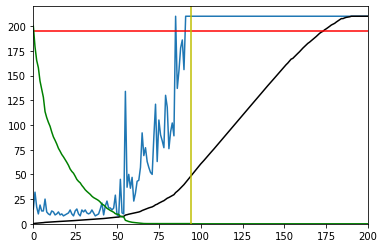

In [12]:
#Plotting
rolling_average = np.convolve(rewards, np.ones(100)/100)

plt.plot(rewards)
plt.plot(rolling_average, color='black')
plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TRAIN_END, color='y', linestyle='-')
plt.xlim( (0,200) )
plt.ylim( (0,220) )
plt.show()

In [14]:
from google.colab import drive
drive.mount('/content/drive')

np.save('/content/drive/My Drive/db/dqn/ddqn/rewards',rewards)
np.save('/content/drive/My Drive/db/dqn/ddqn/TRAIN_END',TRAIN_END)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Changes**  
These are all the same changes as the DQN notebook with the exception of the update weights parameter.  
*hyper parameters*: You can alter alpha, gamma, batch size, and episode length to see what differences the algorithm returns.  
*Training End*: You can also change the line where I only check the last 5 runs before switching to testing mode (if len(rewards) > 5 and np.average(rewards[-5:]) > 195:) as that doesn't prove it was solved. The reason I did this was because I wanted to limit the amount of runs I made.  
*Update Weights*: I call 'dqn.update_target_from_model()' after every episode. You can adjust this to run at different times. I have done per step (no matter how long the episode ran) and I have seen it done every X episodes. Feel free to try different things.

**Conclusion**  
This is a Double Deep Q-Network implementation. There are some changes you can make here and there but it follows the paper as close as I could. If you want to dive deeper you can see that the paper has graphs that dive deeper into the inner workings of the neural network.  

**Reference**  
Van Hasselt, H., Guez, A., & Silver, D. (2016, February). Deep Reinforcement Learning with Double Q-Learning. In AAAI (Vol. 2, p. 5)

## Project Conclusion  
This completes the set of notebooks that cover the original Q-Learner and continues through recent updates. Once you have worked in this area for a while you can see how powerful that first update statement really was. With just some slight tweaks, these algorithms were able to achieve higher scores than even advanced Atari players.  

I hope these notebooks have peaked your interest enough to continue your reinforcement journey.